In [1]:
from fastai2.vision.all import *
from torchvision.models import vgg19, vgg16

In [2]:
_vgg_config = {
    'vgg16' : [1, 11, 18, 25, 20],
    'vgg19' : [1, 6, 11, 20, 29, 22]
}

def _get_layers(arch:str, pretrained=True):
  feat_net = vgg19(pretrained=pretrained).cuda() if arch.find('9') > 1 else vgg16(pretrained=pretrained).cuda()
  config = _vgg_config.get(arch)
  features = feat_net.features.cuda().eval()
  for p in features.parameters():
    p.requires_grad=False
  return feat_net, [features[i] for i in config]

def get_feats(arch:str, pretrained=True):
  feat_net, layers = _get_layers(arch, pretrained)
  hooks = hook_outputs(layers, detach=False)
  def _inner(x):
    feat_net(x)
    return hooks.stored
  return _inner

feats = get_feats('vgg19')

In [3]:
def get_style_im(url):
  download_url(url, 'style.jpg')
  fn = 'style.jpg'
  dset = Datasets(fn, tfms=[PILImage.create])
  dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)
  return dl.one_batch()[0]

url = 'https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg'

style_im = get_style_im(url)
style_im.shape

torch.Size([1, 3, 824, 1000])

In [4]:
def gram(x:Tensor):
  n, c, h, w = x.shape
  x = x.view(n, c, -1)
  return (x @ x.transpose(1, 2))/(c*w*h)

im_feats = feats(style_im)
im_grams = [gram(f) for f in im_feats]

In [5]:
def get_stl_fs(fs): 
    return fs[:-1]

def style_loss(inp:Tensor, out_feat:Tensor):
  "Calculate style loss, assumes we have `im_grams`"
  bs = inp[0].shape[0]
  loss = []
  for y, f in zip(*map(get_stl_fs, [im_grams, inp])):
    loss.append(F.mse_loss(y.repeat(bs, 1, 1), gram(f)))
  # Multiply their sum by 30000
  return 3e5 * sum(loss)

def act_loss(inp:Tensor, targ:Tensor):
  "Calculate the MSE loss of the activation layers"
  return F.mse_loss(inp[-1], targ[-1])

class FeatureLoss(Module):
  "Combines two losses and features into a useable loss function"
  def __init__(self, feats, style_loss, act_loss):
    store_attr(self, 'feats, style_loss, act_loss')
    self.reset_metrics()

  def forward(self, pred, targ):
    # First get the features of our prediction and target
    pred_feat, targ_feat = self.feats(pred), self.feats(targ)
    # Calculate style and activation loss
    style_loss = self.style_loss(pred_feat, targ_feat)
    act_loss = self.act_loss(pred_feat, targ_feat)
    # Store the loss
    self._add_loss(style_loss, act_loss)
    # Return the sum
    return style_loss + act_loss

  def reset_metrics(self):
    # Generates a blank metric
    self.metrics = dict(style = [], content = [])

  def _add_loss(self, style_loss, act_loss):
    # Add to our metrics
    self.metrics['style'].append(style_loss)
    self.metrics['content'].append(act_loss)
    
loss_func = FeatureLoss(feats, style_loss, act_loss)

In [6]:
class ReflectionLayer(Module):
    "A series of Reflection Padding followed by a ConvLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=2):
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out
    
class ResidualBlock(Module):
    "Two reflection layers and an added activation function with residual"
    def __init__(self, channels):
          self.conv1 = ReflectionLayer(channels, channels, ks=3, stride=1)
          self.in1 = nn.InstanceNorm2d(channels, affine=True)
          self.conv2 = ReflectionLayer(channels, channels, ks=3, stride=1)
          self.in2 = nn.InstanceNorm2d(channels, affine=True)
          self.relu = nn.ReLU()

    def forward(self, x):
          residual = x
          out = self.relu(self.in1(self.conv1(x)))
          out = self.in2(self.conv2(out))
          out = out + residual
          return out
        
class UpsampleConvLayer(Module):
    "Upsample with a ReflectionLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=1, upsample=None):
        self.upsample = upsample
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out
    
class TransformerNet(Module):
    "A simple network for style transfer"
    def __init__(self):
        # Initial convolution layers
        self.conv1 = ReflectionLayer(3, 32, ks=9, stride=1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ReflectionLayer(32, 64, ks=3, stride=2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ReflectionLayer(64, 128, ks=3, stride=2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, ks=3, stride=1, upsample=2)
        self.in4 = nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, ks=3, stride=1, upsample=2)
        self.in5 = nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ReflectionLayer(32, 3, ks=9, stride=1)
        # Non-linearities
        self.relu = nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y
    
net = TransformerNet()

In [7]:
path = Path('./cxr_color/')

dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

dls = dblock.dataloaders(path, bs=22)

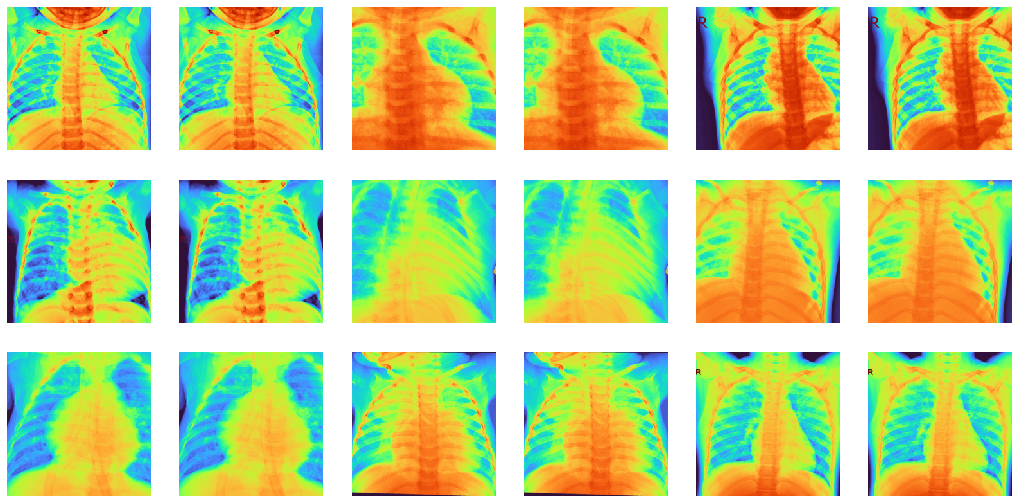

In [8]:
dls.show_batch()

In [9]:
learn = Learner(dls, TransformerNet(), loss_func=loss_func)

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=0.0030199517495930195)

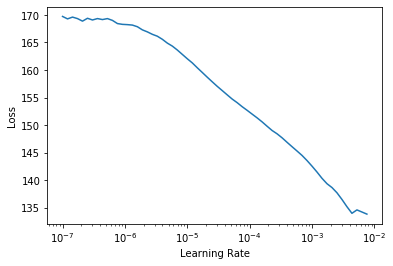

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,time
0,29.606462,27.652233,01:30


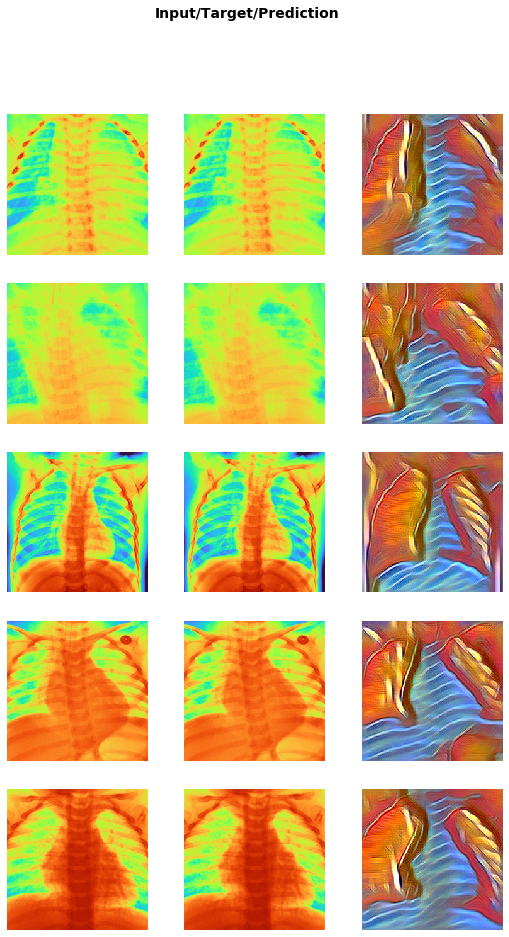

In [12]:
learn.show_results()

In [13]:
learn.save('224')

In [7]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(448)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [8]:
path = Path('./cxr_color/')
dls = dblock.dataloaders(path, bs=8)

In [9]:
learn = Learner(dls, net, loss_func=loss_func).load('224').to_fp16()

In [10]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,time
0,14.863374,14.821521,06:16


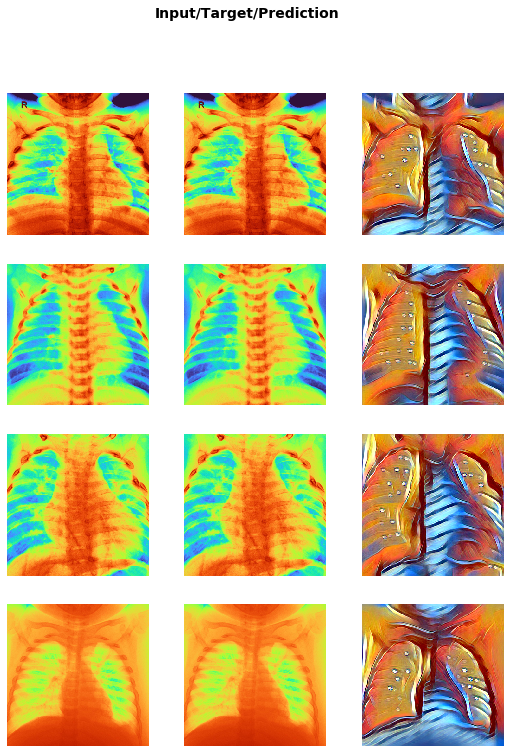

In [11]:
learn.show_results()

In [12]:
learn.save('448')

In [17]:
pred = learn.predict('./cxr_color/val/NORMAL/NORMAL2-IM-1427-0001.jpeg')

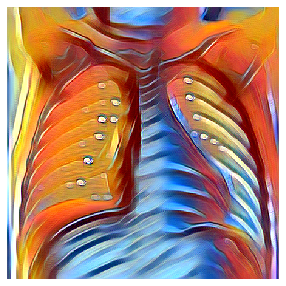

In [18]:
pred[0].show()

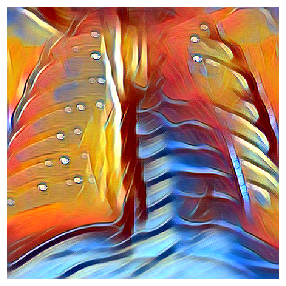

In [19]:
pred = learn.predict('./cxr_color/val/PNEUMONIA/person1946_bacteria_4874.jpeg')
pred[0].show()

In [46]:
im = pred[0].permute(1, 2, 0).numpy().astype('uint8')

In [47]:
plt.imsave('aaa.jpg', im)